   user_id  item_id  rating  timestamp
0        1     1193       5  978300760
1        1      661       3  978302109
2        1      914       3  978301968
3        1     3408       4  978300275
4        1     2355       5  978824291
(1000209, 4)
   MovieID                               title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy
(3883, 3)
   user_id Gender  Age  OccupationID ZipCode
0        1      F    1            10   48067
1        2      M   56            16   70072
2        3      M   25            15   55117
3        4      M   45             7   02460
4        5      M   25            20   55455
(6040, 5)
 

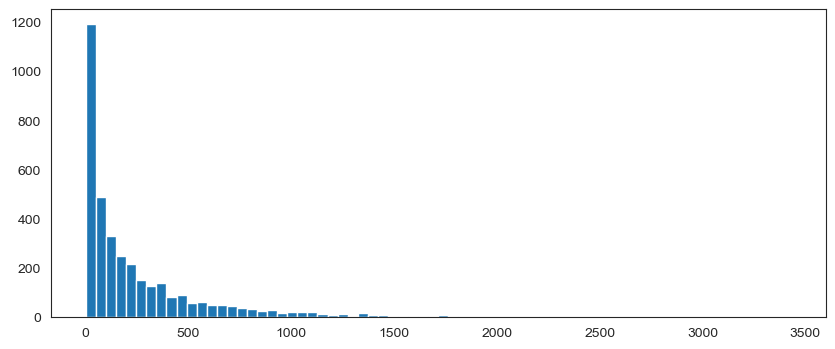

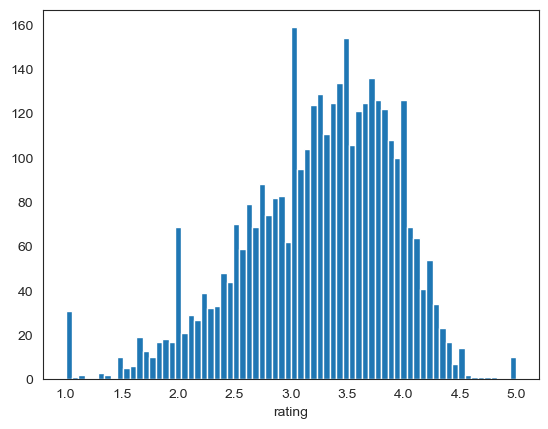

C:\Users\USER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\USER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


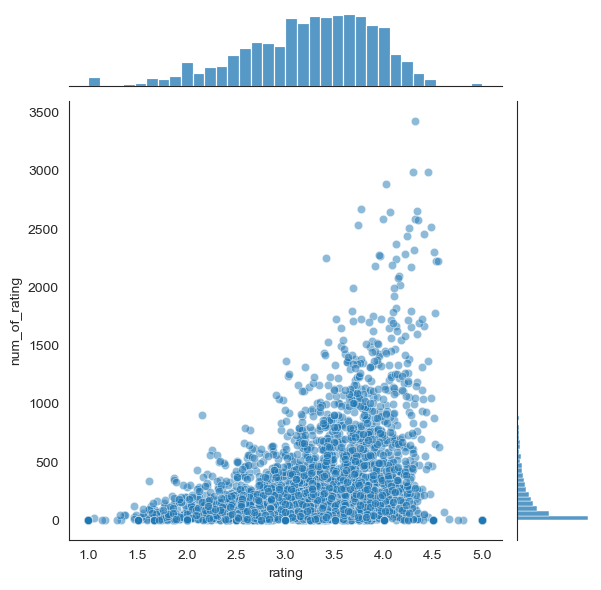

title    $1,000,000 Duck (1971)  'Night Mother (1986)  \
user_id                                                 
1                           0.0                   0.0   
2                           0.0                   0.0   
3                           0.0                   0.0   
4                           0.0                   0.0   
5                           0.0                   0.0   

title    'Til There Was You (1997)  'burbs, The (1989)  \
user_id                                                  
1                              0.0                 0.0   
2                              0.0                 0.0   
3                              0.0                 0.0   
4                              0.0                 0.0   
5                              0.0                 0.0   

title    ...And Justice for All (1979)  1-900 (1994)  \
user_id                                                
1                                  0.0           0.0   
2                        

 * Running on http://127.0.0.1:5001
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn.metrics.pairwise import cosine_similarity

from flask import Flask, request, jsonify

# Initialize Flask app
app = Flask(__name__)

import pandas as pd 
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv(r'C:\Users\USER\Documents\MyPythonProjects\ml-1m\ratings.dat',names=column_names, sep='::', 
                     header=None, 
                     encoding='ISO-8859-1',
                     engine='python')

print(ratings.head())
print(ratings.shape)
movies = pd.read_csv(r'C:\Users\USER\Documents\MyPythonProjects\ml-1m\movies.dat', sep='::', 
                     header=None, 
                     encoding='ISO-8859-1',
                    engine='python')

movies.columns = ['MovieID', 'title', 'Genres']
print(movies.head())
print(movies.shape)

users = pd.read_csv(r'C:\Users\USER\Documents\MyPythonProjects\ml-1m\users.dat', sep='::',
                    header=None,
                     encoding='ISO-8859-1',
                    engine='python')


users.columns = ['user_id', 'Gender', 'Age', 'OccupationID', 'ZipCode']
print(users.head())
print(users.shape)

# Merge ratings with movies on item_id and MovieID
ratings_movies = pd.merge(ratings, movies, left_on='item_id', right_on='MovieID')



# Merge the resulting DataFrame with users on user_id and UserID
full_data = pd.merge(ratings_movies, users, left_on='user_id', right_on='user_id')

print(full_data.head())
print(full_data.shape)
full_data.describe()
columns_to_use = ['user_id','item_id','title','rating']
data = full_data[columns_to_use]
print(data.head())

df = data

# Let's perform EDA to explore the data and look at some of the best rated movies
print(df.groupby('title')['rating'].mean().sort_values(ascending=False).head())
print(df.groupby('title')['rating'].count().sort_values(ascending=False).head())

# Let's create a ratings dataframe with average rating and number of rating
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
print(ratings.head())
ratings['num_of_rating'] = pd.DataFrame(df.groupby('title')['rating'].count())
print(ratings.head())
# Let's do some visualization with histogram
plt.figure(figsize=(10,4))
plt.hist(ratings['num_of_rating'], bins=70)
plt.show()
plt.hist(ratings['rating'], bins=70)
plt.xlabel('rating')
plt.show()

# Let's create a jointplot
sns.jointplot(x="rating", y="num_of_rating", data=ratings,alpha=0.5)
plt.show()

# Now let's create a matrix with user_id on one axis and movie_title on the other axis, each cell will now consist of the rating the users gave to that movie
pivot_table = df.pivot_table(index='user_id', values='rating', columns='title').fillna(0)
print(pivot_table.head())
print(ratings.sort_values('num_of_rating', ascending=False).head())


# Create a pivot table
#pivot_table = df.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

# Step 2: Calculate Item Similarity
item_similarity = cosine_similarity(pivot_table.T)
item_similarity_df = pd.DataFrame(item_similarity, index=pivot_table.columns, columns=pivot_table.columns)

# Step 3: Calculate User Similarity
user_similarity = cosine_similarity(pivot_table)
user_similarity_df = pd.DataFrame(user_similarity, index=pivot_table.index, columns=pivot_table.index)

# Step 4: Generate Hybrid Recommendations
def get_hybrid_recommendations(user_id, num_recommendations=5):
    # Get user-based recommendations
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)
    similar_users_ratings = pivot_table.loc[similar_users.index]
    user_weighted_ratings = similar_users_ratings.T.dot(similar_users)

    # Get item-based recommendations
    user_ratings = pivot_table.loc[user_id]
    item_based_recommendations = item_similarity_df.dot(user_ratings).sort_values(ascending=False)

    # Combine recommendations
    combined_recommendations = user_weighted_ratings.add(item_based_recommendations, fill_value=0)

    # Remove movies already rated by the user
    combined_recommendations = combined_recommendations[user_ratings == 0]

    # Get the top recommendations
    final_recommendations = combined_recommendations.sort_values(ascending=False).head(num_recommendations)

    return final_recommendations.index.tolist()
get_hybrid_recommendations(1)
# Define a route for recommendations
@app.route('/recommend', methods=['GET'])
def recommend():
    user_id = request.args.get('user_id', type=int)
    if user_id is None:
        return jsonify({"error": "Please provide a user_id."}), 400
    
    recommendations = get_hybrid_recommendations(user_id)
    return jsonify({"user_id": user_id, "recommendations": recommendations})

# Run the app
if __name__ == "__main__":
    app.run(debug=True, port=5001)

